### Logistic Regression to predict if song titles contain love

For this project, we were interested in a songs dataset from the Spotify API. We found that love was one of the most frequent words used in song titles. For this reason, we decided that we wanted to explore what variables were associated with a song being about love, measured by it having love in the title. To ask this specifically, our question of interest was:
Does popularity score or valence affect if a song will be about love?
For this question, we decided that we wanted our output to be a prediction of the probability of a song having love in it, which would be best represented using a logistic regression.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import seaborn as sns


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [22]:
#Read in datasets
spotify_data = pd.read_csv("../data/spotify_data.csv")

In [23]:
#Adding Has Love column
song_attribute_data = spotify_data

titles = song_attribute_data["Song"]
titles = titles.str.split(pat=" ", expand=True)

song_attribute_data["Has Word Love?"] = song_attribute_data['Song'].str.contains("Love")
song_attribute_data_love = song_attribute_data[song_attribute_data["Has Word Love?"]]

song_attribute_data = song_attribute_data.dropna()


In [24]:
#Prepare X and y
y = song_attribute_data["Has Word Love?"]
X = song_attribute_data.loc[:,["speechiness", "valence", "tempo", "time_signature", "Popularity Points Awarded"]]

def minmax(z):
    z = (z-min(z))/(max(z)-min(z))
    return z
X = X.apply(minmax,axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=100)

reg = LogisticRegression(penalty = None,
                         fit_intercept=True,
                         solver = 'newton-cholesky',
                         max_iter=1000).fit(X_train,y_train)

print("Training R^2" , reg.score(X_train, y_train))
print("Test R^2", reg.score(X_test, y_test))

Training R^2 0.9174862912350944
Test R^2 0.9136790810998956


We tried running regression without balancing "Has Love", but it kept returning the same R^2 reguardless of which variables we selected. Our target variable is highly imbalanced. Almost 92% of the songs do not have the word 'love' in the title, so our model has learned to always return an accuracy close to 1, which explains why the model always gives an accuracy close to .91 no matter what features or how many features we use.

Thus, below, we will add a new parameter called class_weight="balanced" to tell our model to care and focus more on the underrepresented population, which in this case is True: the title has the word 'love'.

In [25]:
print(song_attribute_data["Has Word Love?"].value_counts(normalize=True))


Has Word Love?
False    0.916725
True     0.083275
Name: proportion, dtype: float64


Let's see how the accuracy scores changed after adding this new parameter, class_weight="balanced", that tells the model to focus more on the underrepresented data.

In [26]:
#Prepare X and y
y = song_attribute_data["Has Word Love?"]
X = song_attribute_data.loc[:,["speechiness", "valence", "tempo", "time_signature", "Popularity Points Awarded"]]

X = X.apply(minmax,axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=100)

#Run Regression
reg = LogisticRegression(penalty = None,
                         fit_intercept=True,
                         solver = 'newton-cholesky',
                         max_iter=1000,
                         class_weight='balanced').fit(X_train,y_train)

print("Training R^2" , reg.score(X_train, y_train))
print("Test R^2", reg.score(X_test, y_test))
# We can see that the accuracy decreased

Training R^2 0.324310209765863
Test R^2 0.33379742429516185


Without adjusting:

- Training R^2 0.9174862912350944
- Test R^2 0.9136790810998956

After adjusting:

- Training R^2 0.324310209765863
- Test R^2 0.33379742429516185

We can see that the accuracy decreased

In [27]:
#Run regression with all variables
X_n = song_attribute_data.iloc[:, [8] + [9] + list(range(11, 24))]
X_n = X_n.apply(minmax,axis=1)

dummies = pd.DataFrame([])
new_dummies = pd.get_dummies(song_attribute_data.loc[:,"spotify_track_explicit"], drop_first=True, dtype=int)
dummies = pd.concat([dummies, new_dummies], axis=1, ignore_index=True)

X2 = pd.concat([X_n,dummies],axis=1)
X2.columns = X2.columns.astype(str)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y, test_size=.2, random_state=100)

reg2 = LogisticRegression(penalty = None,
                         fit_intercept=True,
                         solver = 'newton-cholesky',
                         max_iter=1000,
                         class_weight='balanced'
                         ).fit(X2_train,y2_train)

print("Training R^2", reg2.score(X2_train, y2_train))
print("Test R^2", reg2.score(X2_test, y2_test))
pd.DataFrame(reg2.feature_names_in_, reg2.coef_[0])
#Return coefficients for each variable to see which are stronger predictors.

Training R^2 0.5130124466881365
Test R^2 0.5144448311869126


,0
1.979786,spotify_track_duration_ms
300880.974906,spotify_track_explicit
-99041.854804,danceability
-34060.232917,energy
-512.231218,key
-379624.544851,loudness
-8324.074773,mode
-261643.989204,speechiness
80341.412353,acousticness
-48870.250866,instrumentalness


In [28]:
#Try running regression with variables that had highest coefficients
y = song_attribute_data["Has Word Love?"]
X = song_attribute_data.loc[:,["spotify_track_explicit", "loudness", "speechiness"]]

def minmax(z):
    z = (z-min(z))/(max(z)-min(z))
    return z
X = X.apply(minmax,axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=100)

#Run Regression
reg = LogisticRegression(penalty = None,
                         fit_intercept=True,
                         solver = 'newton-cholesky',
                         max_iter=1000,
                         class_weight='balanced'
                         ).fit(X_train,y_train)

print("Training R^2" , reg.score(X_train, y_train))
print("Test R^2", reg.score(X_test, y_test))
#Value is not very high, coefficients may not be best for finding significant variables

Training R^2 0.4456436591522326
Test R^2 0.4629307344239471


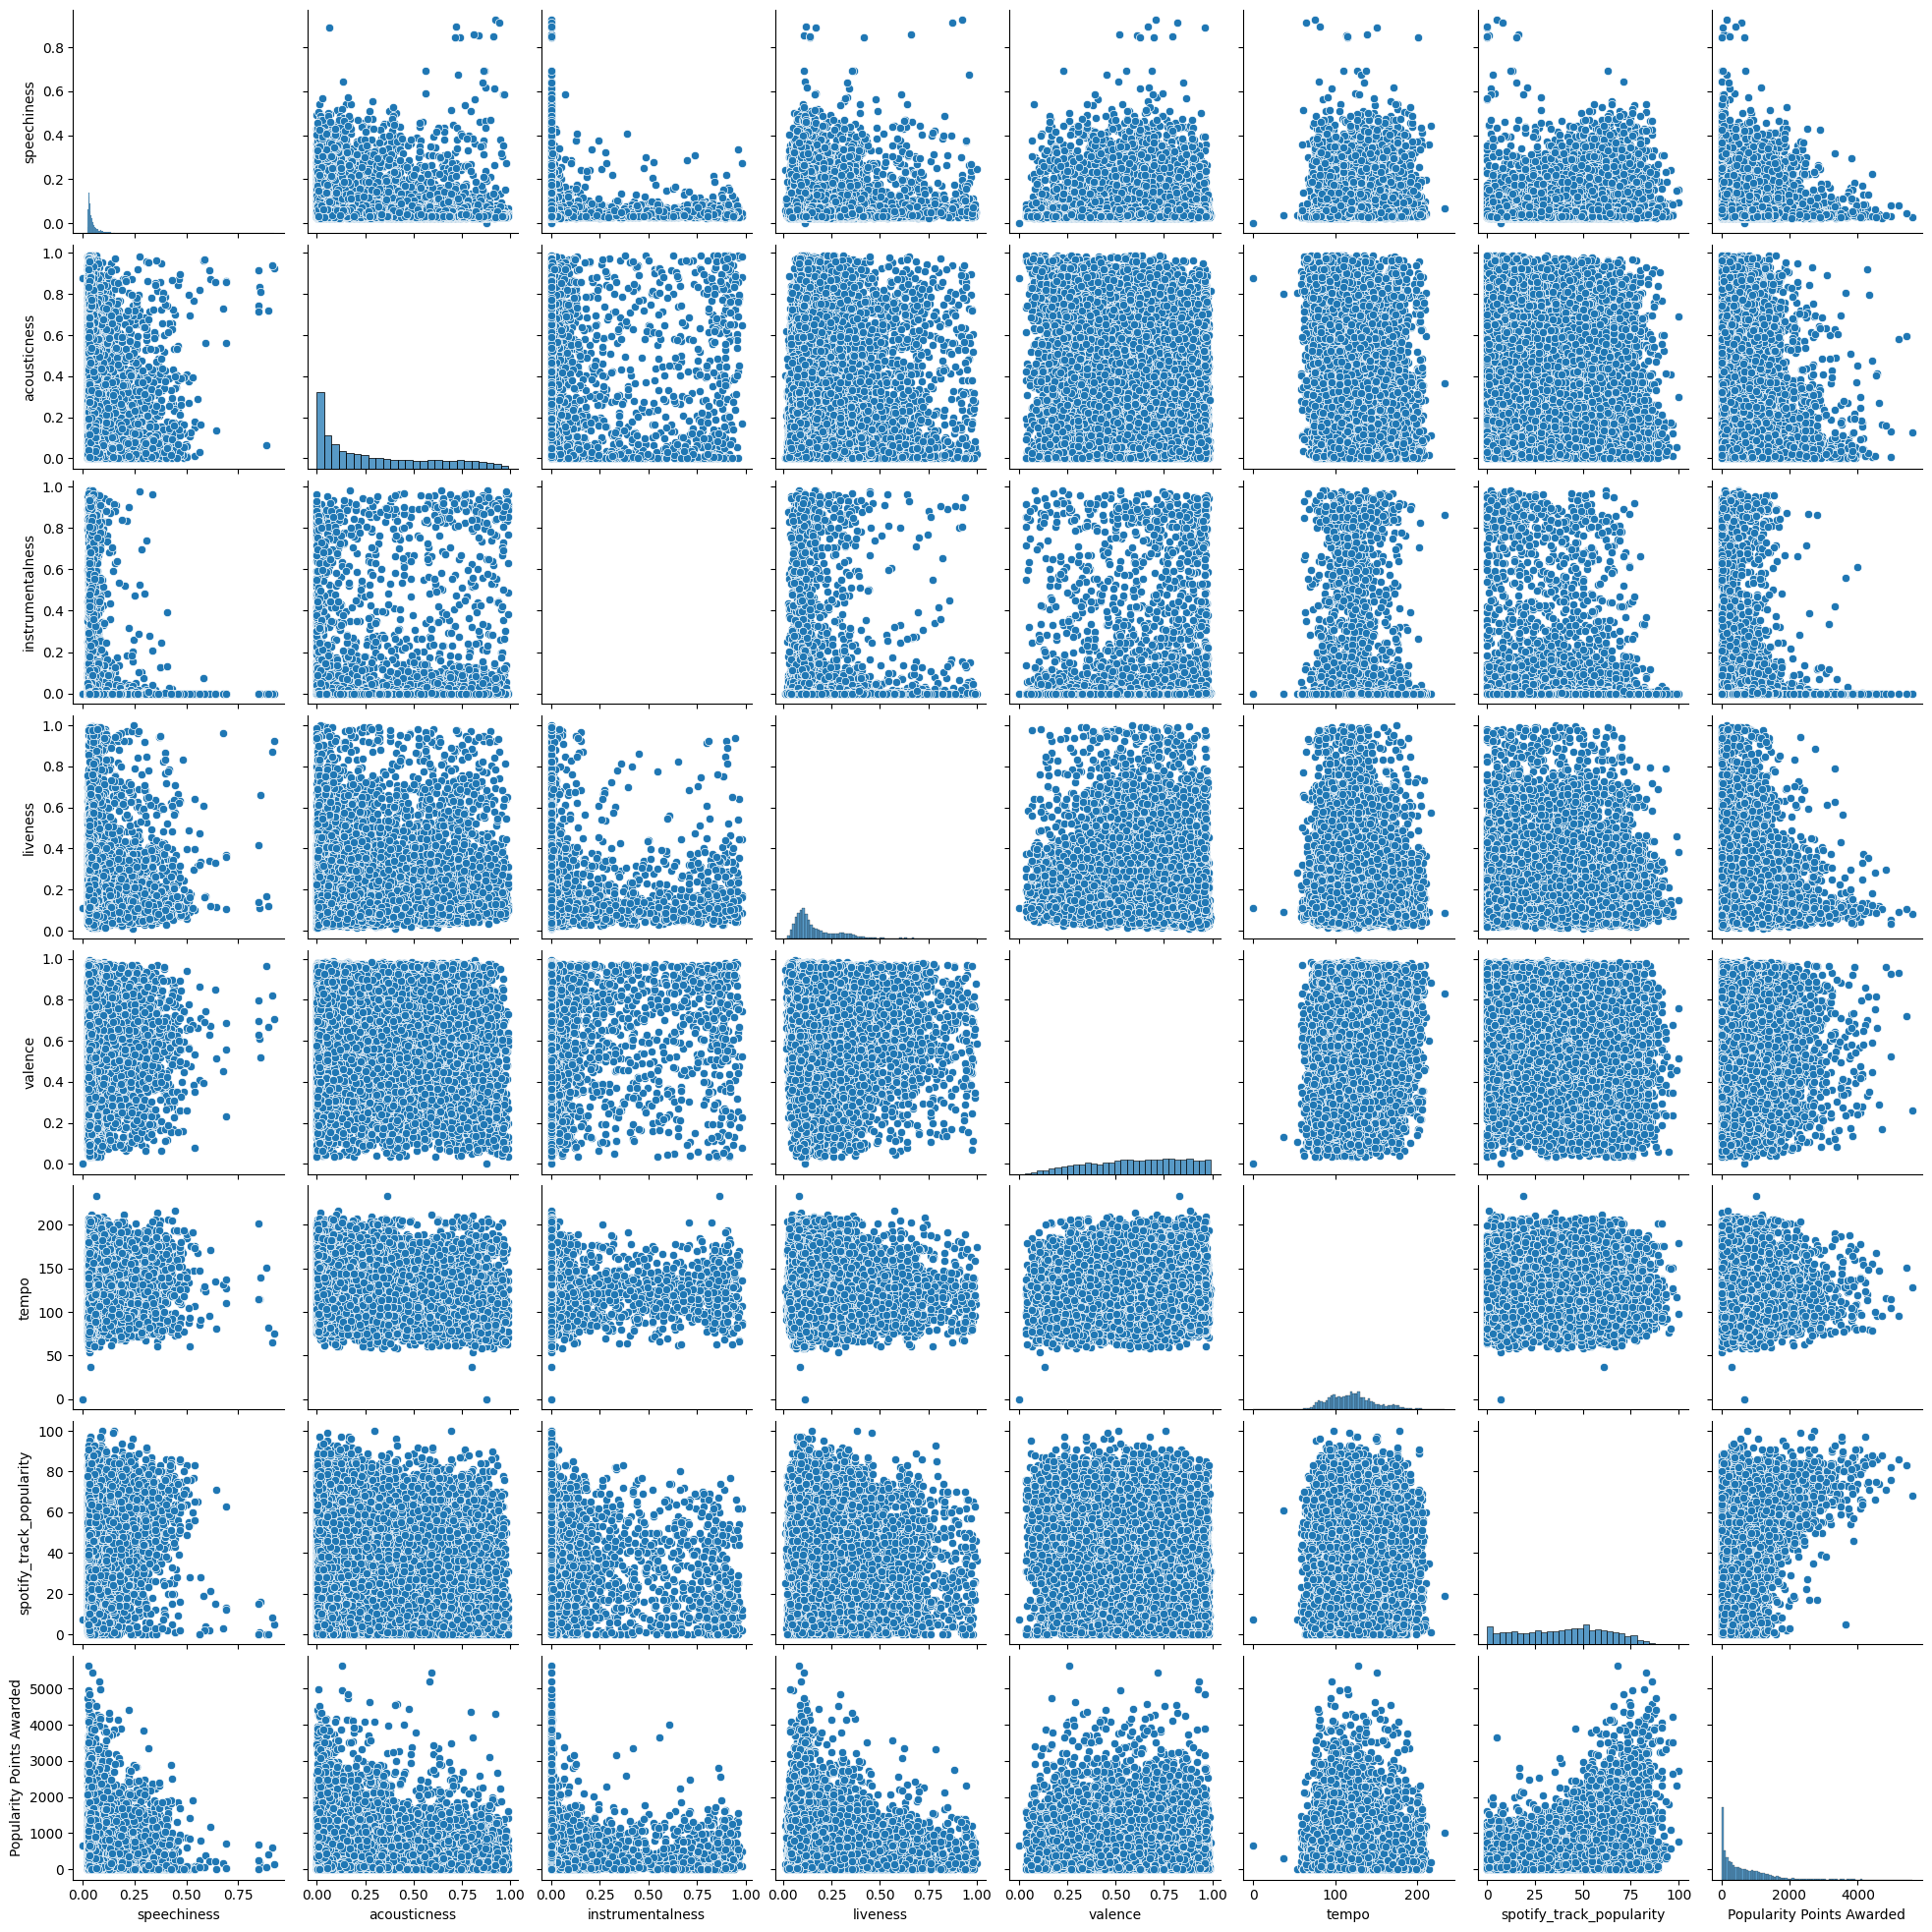

In [29]:
#Create pairplot to examine any potential relationships between variables
X=song_attribute_data.loc[:,['speechiness', 'acousticness', 'instrumentalness',	'liveness',	'valence', 'tempo',	'spotify_track_popularity', 'Popularity Points Awarded']]
sns.pairplot(X)
#Don't seem to be any interaction relationships to add to the model

We can see that the accuracy scores are worse, but by using all the variables, the features explained more of the variance compared to cherry picking which variables to use.

Let's try some more feature combinations using class_weight = 'balanced'

In [30]:
# Do more popular songs have the word 'love'?
#Prepare X and y
y = song_attribute_data["Has Word Love?"]
X = song_attribute_data.loc[:,["Popularity Points Awarded"]]

def minmax(z):
    z = (z-min(z))/(max(z)-min(z))
    return z
X = X.apply(minmax,axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=100)

#Run Regression
reg = LogisticRegression(penalty = None,
                         fit_intercept=True,
                         solver = 'newton-cholesky',
                         max_iter=1000,
                         class_weight='balanced'
                         ).fit(X_train,y_train)

print("Training R^2" , reg.score(X_train, y_train))
print("Test R^2", reg.score(X_test, y_test))

Training R^2 0.4069109583079467
Test R^2 0.40932822833275323


In [31]:
song_attribute_data.head()

,Unnamed: 0,index,SongID,Performer,Song,spotify_genre,spotify_track_id,spotify_track_preview_url,spotify_track_duration_ms,spotify_track_explicit,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,spotify_track_popularity,Popularity Points Awarded,Has Word Love?
2,2,2,......And Roses And RosesAndy Williams,Andy Williams,......And Roses And Roses,"['adult standards', 'brill building pop', 'eas...",3tvqPPpXyIgKrm4PR9HCf0,https://p.scdn.co/mp3-preview/cef4883cfd1e0e53...,166106.0,False,...,0.0315,0.9110,0.000267,0.1120,0.150,83.969,4.0,38.0,362.0,False
4,4,4,...Baby One More TimeBritney Spears,Britney Spears,...Baby One More Time,"['dance pop', 'pop', 'post-teen pop']",3MjUtNVVq3C8Fn0MP3zhXa,https://p.scdn.co/mp3-preview/da2134a161f1cb34...,211066.0,False,...,0.0307,0.2020,0.000131,0.4430,0.907,92.960,4.0,77.0,2727.0,False
7,7,7,'65 Love AffairPaul Davis,Paul Davis,'65 Love Affair,"['album rock', 'bubblegum pop', 'country rock'...",5nBp8F6tekSrnFg8G2Pvug,https://p.scdn.co/mp3-preview/a701445830ecacfb...,219813.0,False,...,0.0274,0.4320,0.000006,0.1330,0.952,155.697,4.0,40.0,1300.0,True
10,10,10,'til I Can Make It On My OwnTammy Wynette,Tammy Wynette,'til I Can Make It On My Own,"['country', 'country dawn', 'nashville sound']",0aJHZYjwbfTmeyUWF7zGxI,https://p.scdn.co/mp3-preview/73a24c43d2b48dc5...,182080.0,False,...,0.0318,0.8320,0.000035,0.1080,0.146,141.148,4.0,31.0,43.0,False
12,12,12,'Til My Baby Comes HomeLuther Vandross,Luther Vandross,'Til My Baby Comes Home,"['funk', 'motown', 'neo soul', 'new jack swing...",2R97RZWUx4vAFbMMtmb5Ss,https://p.scdn.co/mp3-preview/c54184ec2fc7e8bd...,332226.0,False,...,0.1830,0.0567,0.000006,0.0253,0.802,139.663,4.0,29.0,721.0,False


In [32]:
song_attribute_data.describe()

,Unnamed: 0,index,spotify_track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,spotify_track_popularity,Popularity Points Awarded
count,14362.000000,14362.000000,1.436200e+04,14362.000000,14362.000000,14362.000000,14362.000000,14362.000000,14362.000000,14362.000000,14362.000000,14362.000000,14362.000000,14362.000000,14362.000000,14362.000000,14362.000000
mean,14820.067818,14820.067818,2.201252e+05,0.598544,0.617135,5.268138,-8.747932,0.729982,0.070314,0.299108,0.036778,0.191856,0.606099,120.491633,3.929188,39.688901,593.743211
std,8508.384232,8508.384232,6.924285e+04,0.154128,0.200268,3.547723,3.570442,0.443984,0.078154,0.286749,0.147008,0.159347,0.238582,27.825711,0.320698,22.711952,643.748511
min,2.000000,2.000000,6.774900e+04,0.000000,0.000581,0.000000,-28.030000,0.000000,0.000000,0.000006,0.000000,0.009670,0.000000,0.000000,0.000000,0.000000,1.000000
25%,7423.500000,7423.500000,1.741468e+05,0.497000,0.473000,2.000000,-11.075750,0.000000,0.031900,0.046000,0.000000,0.090600,0.422000,99.454750,4.000000,20.000000,94.000000
50%,14817.500000,14817.500000,2.144000e+05,0.607000,0.632000,5.000000,-8.316500,1.000000,0.040900,0.198000,0.000005,0.131000,0.627000,119.516000,4.000000,41.000000,388.000000
75%,22154.750000,22154.750000,2.529428e+05,0.708000,0.778000,8.000000,-5.987000,1.000000,0.066200,0.522000,0.000587,0.248000,0.808000,136.619000,4.000000,58.000000,911.000000
max,29502.000000,29502.000000,3.079157e+06,0.986000,0.997000,11.000000,2.291000,1.000000,0.924000,0.990000,0.982000,0.999000,0.991000,233.429000,5.000000,100.000000,5615.000000


In [33]:
# make a table with single features

In [34]:
list_features = ['spotify_track_duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',	'liveness',	'valence', 'tempo',	'spotify_track_popularity', 'Popularity Points Awarded']
features = []
trainr2 = []
testr2 = []

for feature in list_features:
    y = song_attribute_data["Has Word Love?"]
    X = song_attribute_data.loc[:,[feature]]

    X = X.apply(minmax,axis=0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=100)

    # Run Regression
    reg = LogisticRegression(penalty = None,
                         fit_intercept=True,
                         solver = 'newton-cholesky',
                         max_iter=1000,
                         class_weight='balanced').fit(X_train,y_train)
    features.append(feature)
    trainr2.append(reg.score(X_train, y_train))
    testr2.append(reg.score(X_test, y_test))

    #print(feature)
    #print("Training R^2" , reg.score(X_train, y_train))
    #print("Test R^2", reg.score(X_test, y_test))

combined_lists = list(zip(features, trainr2, testr2))

# Place your combined_lists into a pandas data frame, add column headers using the
df_combined_lists = pd.DataFrame(combined_lists, columns=['Feature', 'Train R^2', 'Test R^2'])

# Print your data frame out for us to view
df_combined_lists

,Feature,Train R^2,Test R^2
0,spotify_track_duration_ms,0.535469,0.542986
1,danceability,0.560623,0.534981
2,energy,0.563234,0.562130
3,key,0.489512,0.490776
4,loudness,0.577944,0.577445
5,mode,0.309252,0.310129
6,speechiness,0.342763,0.362687
7,acousticness,0.616764,0.602506
8,instrumentalness,0.162155,0.169509
9,liveness,0.643050,0.635921


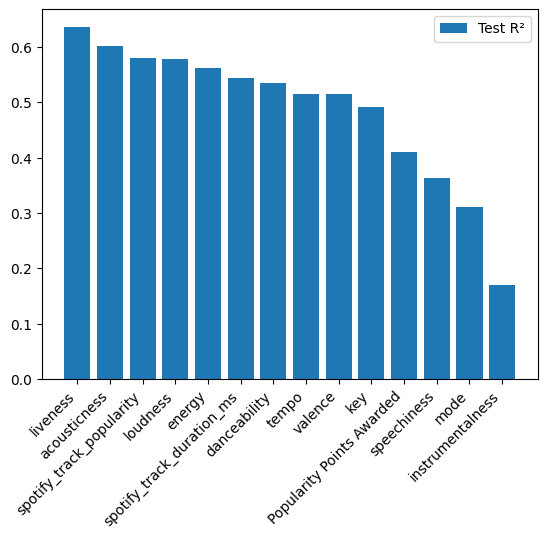

In [35]:
df_combined_lists = df_combined_lists.sort_values(by='Test R^2', ascending=False)
x = np.arange(len(df_combined_lists['Feature']))
plt.bar(x, df_combined_lists['Test R^2'], label='Test R²')
plt.xticks(x, df_combined_lists['Feature'], rotation=45, ha='right')
plt.legend()

From this, we can see by running regression with just one variable, liveness, acousticness, and spotify_track_popularity had the highest R^2 scores. This may lead us to believe that these are the most influential to determining if a song has love in it. Interestingly, track popularity is a lot higher than popularity points awarded.

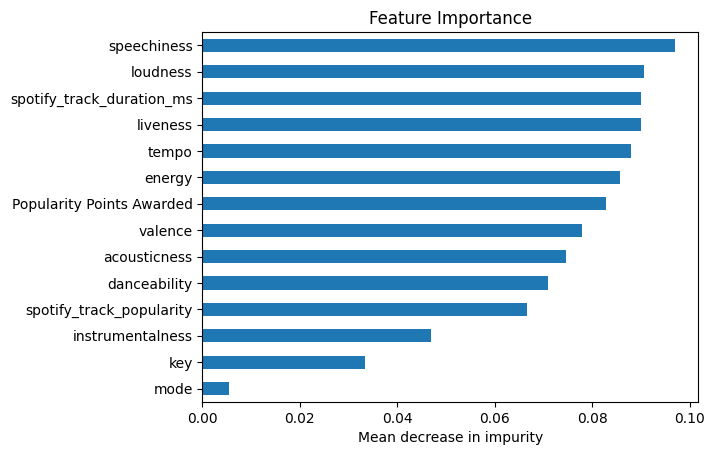

In [37]:
#Trying random forest
from sklearn.ensemble import RandomForestRegressor

X = song_attribute_data.loc[:,['spotify_track_duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',	'liveness',	'valence', 'tempo',	'spotify_track_popularity', 'Popularity Points Awarded']]
X = X.apply(minmax,axis=0)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=100)

model = RandomForestRegressor(max_depth=10)
rf = model.fit(X_train,y_train)

y_hat_rf = rf.predict(X_test)

feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns )
feature_importances.sort_values().plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Mean decrease in impurity')
plt.show()

## Conclusion

In the end, our tests at regression returned some different variables than using random forest feature importance. They both had liveness in the top three. The individual regressions told us liveness, acousticness, and spotify_track_popularity had the greatest influence, and that instrumentalness had the least influence. From our random forest we saw that tempo, liveness, and Popularity Points Awarded were the three most influential features, and that instrumentalness was the least important. As the tests did share liveness as having a large influence, there is some predictive possibilities with variables in music. However the variation of influential variables highlights the subjectivity of music which makes predictions related to it quite difficult.